# This is a starter point for EDA for email conversion data

In [70]:
import pandas as pd
import numpy as np
import matplotlib as plt
import plotly as py
import seaborn as sb
import os
import sys
import plotly.figure_factory as ff

In [38]:
df = pd.read_csv('conversion_data.csv')

first let's check on the data file size, data type, and basic statistical information

In [93]:
df.shape

(5214468, 12)

In [40]:
df.describe()

,id,value,email_id,brand_id,promotionalunit_id,cookie_id
count,5.214468e+06,5.214468e+06,3.999819e+06,5.214468e+06,1.055407e+06,1.145911e+06
mean,2.609144e+06,6.262629e+01,9.642850e+06,3.992835e+03,2.055130e+04,4.604196e+06
std,1.505491e+06,3.823108e+03,4.506288e+06,2.591073e+03,1.251461e+04,2.503399e+06
min,1.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,6.600000e+01,3.697000e+03
25%,1.305616e+06,0.000000e+00,6.034170e+06,1.142000e+03,1.385600e+04,2.504334e+06
50%,2.609270e+06,2.000000e+01,1.194058e+07,4.464000e+03,1.881300e+04,4.400128e+06
75%,3.912886e+06,6.800000e+01,1.319826e+07,6.424000e+03,2.081500e+04,6.778536e+06
max,5.216537e+06,8.710000e+06,1.459597e+07,7.974000e+03,9.993800e+04,9.285089e+06


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5214468 entries, 0 to 5214467
Data columns (total 12 columns):
id                    int64
value                 int64
currency              object
order_id              object
created_at            object
updated_at            object
email_id              float64
brand_id              int64
promotionalunit_id    float64
conversion_type       object
cookie_id             float64
transaction_date      object
dtypes: float64(3), int64(3), object(6)
memory usage: 477.4+ MB


In [49]:
df.head()

,id,value,currency,order_id,created_at,updated_at,email_id,brand_id,promotionalunit_id,conversion_type,cookie_id,transaction_date
0,1996226,17,USD,1.12569e+12,2019-04-17 11:02:00,2019-04-17 11:02:00,11966208.0,5477,NaN,shopify,NaN,2019-04-17 11:01:53
1,1996234,0,USD,NaN,2019-04-17 11:02:55,2019-04-17 11:02:55,NaN,1037,NaN,DOJO,2424675.0,NaN
2,2023386,50,USD,9.9728e+11,2019-04-17 20:55:51,2019-04-17 20:55:51,12431071.0,6401,NaN,shopify,NaN,2019-04-17 20:55:40
3,2023568,0,USD,NaN,2019-04-17 21:08:11,2019-04-17 21:08:11,NaN,1037,NaN,DOJO,2448882.0,NaN
4,2023647,0,USD,NaN,2019-04-17 21:12:07,2019-04-17 21:12:07,NaN,1037,NaN,DOJO,2449066.0,NaN


Let's check on the value data distribution

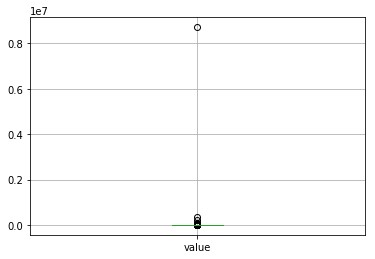

In [67]:

df[['value']].boxplot()


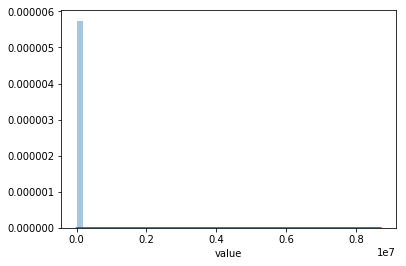

In [79]:
sb.distplot(df['value'])

In [81]:
df[['value']].describe()

,value
count,5.214468e+06
mean,6.262629e+01
std,3.823108e+03
min,0.000000e+00
25%,0.000000e+00
50%,2.000000e+01
75%,6.800000e+01
max,8.710000e+06


The value data is really skewed to the right so we should be aware of that in the modeling

The entry numbers of data is around 5 million

In [145]:
data_points = df.shape[0]
data_points

5214468

After grouping by the brand_id, here's how many unique conversions on email each brand have

In [137]:
sources = pd.DataFrame(df[['id','brand_id']].groupby(['brand_id']).nunique().iloc[:,0])
sources.columns = ['email_count']
sources.head()

,email_count
brand_id,
3,4053
52,13672
55,1
56,48463
60,289


Here's how much money on average each email spend on one campaign

In [130]:
avg_spent = pd.DataFrame(df[['email_id', 'value']].groupby(['email_id']).mean())
avg_spent.columns = ['Average spend per email id']
avg_spent.head()

,Average spend per email id
email_id,
1.0,36.000000
2.0,0.000000
5.0,5.841270
6.0,3.333333
28.0,0.000000


Here's how much money on average spent by each brand sources

In [134]:
avg_b_spent = pd.DataFrame(df[['brand_id', 'value']].groupby(['brand_id']).mean())
avg_b_spent.columns = ['Average spend per source']
avg_b_spent.head()

,Average spend per source
brand_id,
3,45.744140
52,60.342232
55,108.000000
56,86.039494
60,0.000000


Here's the list of emails that purchased in more than one brand that Dojo has and the number of brands they purchases in 

In [139]:
email_spent = pd.DataFrame(df[['email_id', 'brand_id']].groupby(['email_id']).nunique())[['brand_id']]
email_spent_mult = email_spent.drop(email_spent[email_spent['brand_id'] == 1].index, axis = 0)
email_spent_mult.columns = ['num_brand_purchase']
email_spent_mult.head()

,num_brand_purchase
email_id,
1.0,2
28.0,2
45.0,2
53.0,2
69.0,2


The statistics comparison for multi-brand emails and all-brand emails

In [153]:
compare1 = email_spent_mult.describe()
compare2 = email_spent.describe()
compare = pd.concat([compare1, compare2], axis = 1)
compare.columns = ['multi-brand-emails', 'all-emails']
compare['relative-change'] = compare.apply(lambda row: row['multi-brand-emails']/ row['all-emails'], axis = 1)
compare

,multi-brand-emails,all-emails,relative-change
count,93961.000000,2.108375e+06,0.044566
mean,2.145326,1.051042e+00,2.041142
std,0.470597,2.563672e-01,1.835639
min,2.000000,1.000000e+00,2.000000
25%,2.000000,1.000000e+00,2.000000
50%,2.000000,1.000000e+00,2.000000
75%,2.000000,1.000000e+00,2.000000
max,43.000000,4.300000e+01,1.000000


The percentage of the emails spending on more than one brands of all the emails

In [142]:
rate = float(email_spent_mult.shape[0]/email_spent.shape[0])
rate

0.04456560147032668